7-FEB-2021
# Traffic Sign Recognition
Implement a convolutional neural network that recognizes traffic signs.

![](./wup_assets/notLenetValAcc.png)

## Goals
- Explore, summarize, and visualize traffic sign data
- Design, train and test a model architecture
- Use the model to make predictions on new images
- Analyze the softmax probabilities of the new images
- Experiment with a Multi-Scale CNN


## Dataset Exploration

The traffic signs are contained in the `data` folder, contained in `train.p`, `valid.p`, and `test.p`. The file `signnames.csv` mapped the class ID number to the name of the type of sign. 

### Data Summary

Loading and examining the data yielded the following characteristics:
- Training Samples: 34,799
- Testing Samples: 12,630
- Image Shape: 32x32x3
- Number of types of Signs: 43


### Data Visualization

Below are some images from each of the 43 types of traffic signs (from the Training Samples). 

Many images are very dark and will need brightness increased. 

Color, shape, and orientation matters for interpretation.

![](wup_assets/TrafficSignsByType.png)

### Sign Type Proportionality

There is a large imbalance in the prorportion of each type of sign found in each dataset (below). 

For example, the proportion of "Speed limit (20km/h)" signs present in the dataset is much less than the proportion of "Speed limit (50km/h)" signs. 

Additional signs will be generated to fix this disproportion so the model has a better chance to be equally exposed to all types of signs during training and hopefully improve validation accuracy.

![](wup_assets/PctByType.png)


## Design and Test a Model Architecture

### Preprocessing

Fake images will be generated for the training dataset to address the imbalance in the number of signs for each type of sign. Images will then be brightened then normalized prior to submission for training. 

#### Generating Fake Images

Similar to Sermanet and Lecun in _"Traffic Sign Recognition with Multi-Scale Convolutional Networks"_, shifting, rotation, and scaling (zooming in) is randomly performed on traffic signs generated to augment the dataset. These manipulations will expose the model to different variations of the generated image during training.

```python
def shift(image, d=None):
    '''
    Shifts image left, right, up or down from 1 to 6 pixels. 
    Used in generating additional training samples.
    '''
    if d is None:
        d = random.randint(1, 6)
    direction = random.choice([1, 2, 3, 4])
    if direction == 1:
        image[:-d] = image[d:]
    elif direction == 2:
        image[d:] = image[:-d]
    elif direction == 3:
        image[:,d:] = image[:,:-d]
    else:
        image[:,:-d] = image[:,d:]
        
    return image

def crop(image, size=32):
    '''
    Crops image to 32x32. Used after image is zoomed in.
    '''
    sizes = np.array(image.shape[:2]) - 32
    lower =  sizes // 2
    upper = image.shape[:2] - (lower + (sizes % 2))
    img = image[lower[0]:upper[0], lower[1]:upper[1]]
    return img

def zoom(image, scale=None):
    '''
    Zooms in on an image from 1.0x to 1.6x. Uses crop to ensure img is 32x32
    Used in generating additional training samples.
    '''
    if scale is None:
        scale = random.uniform(1.0, 1.6)
    img = sk.transform.rescale(image, scale, multichannel=True, preserve_range=True).astype(np.uint8)
    return crop(img)

def rotate (image, deg=None):
    '''
    Rotates image from -15 to 15 degrees.
    Used in generating additional training samples.
    '''
    if deg is None:
        deg = random.uniform(-15, 15)
    return sk.transform.rotate(image, deg, preserve_range=True).astype(np.uint8)
```

#### Larger and Balanced Training Set

After adding the fake images, the training set grew from 34,799 to 259,290 samples. This increase in the amount of training data helped push the model to high validation accuracies during experimentation. The fake images were generated in such a way as to achieve a balance in proportion accross each type of traffic sign.

![](./wup_assets/EqualPortionsTraining.png)

#### Brightening Dark Images

`equalizeHist()` from `opencv` was used to brighten dark images. The image is first converted to the HSV colorspace. Then if the average value of the V-component, `mean_v`, is less than the default `v_thresh` of 128, `equalizeHist()` is applied:

```python
def equalizeHist(orgimg, v_thresh=128):
    '''
    Brightens dark images.
    
    Params:
    - orgimg: original image (RGB)
    - v_thresh: max integer of the average value of the image for brightening to occur
    '''
    hsv = cv2.cvtColor(orgimg, cv2.COLOR_RGB2HSV)
    mean_v = np.mean(hsv[:,:,2])
    if mean_v < v_thresh:
        equ = cv2.equalizeHist(hsv[:,:,2])
        hsv[:,:,2] = equ
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    else:
        img = orgimg
    return img
```

#### Normalizing Image Data

"A guiding principle in developing the model architecture is for the inputs to have a mean of 0.0 (zero) and have equal variance" (see [Normalized Inputs and Initialization](https://youtu.be/WaHQ9-UXIIg?t=22). This makes it easier for the Tensorflow optimizer to discover appropriate parameters (weights and biases) during training. The `function RGB_to_norm()` is applied to normalize the images:

```python
def RGB_to_norm(img):
    return (np.float32(img) - 128)/128
```

#### Examples of Processed Image

Below shows the effects of applying brightening, rotation, zoom, and shifting to a sample image:

![](./wup_assets/BrightenFake.png)


### Model Architecture

The model architecture generally follows the LeNet architecture outlined in _Lesson 13: Convolutional Neural Networks, Item 36. Lab: LeNet in Tensorflow_.

A 1x1 convolution used in the very first layer has an output shape of 32x32x1. This forces the model to compress the 3 RGB channels of the Input layer into 1 channel, thus achieving a grayscaling effect, but allowing the model to determine the significance of each channel value. The improved validation accuracy was quite astonishing as compared to training the model without this 1x1 convolution in the first layer. 

The other convolutional layers have the same first and second dimensions as LeNet, but are deeper (24 and 64 respectively. The fully connected layers are wider with dropout added in the later stages. The  deepening of the convolutions, widening of the connections, and addition of dropout seemed to improve validation accuracy during experimentation.

A custom set of high level classes (`Layers`, `Conv2D`, `Pooling`, `Flatten`, `Connected`, `Dropout`, `Model`, `Sequential`) which wrap `tensorflow` are used to help code the model, named `notLenet`, in a Keras-like fashion.

```python
notLenet = Sequential("notLeNet", input_shape=image_shape, n_classes=n_classes)

notLenet.addLayer (Conv2D   ([32, 32, 1]))
notLenet.addLayer (Conv2D   ([28, 28, 24]))
notLenet.addLayer (Pooling  ([14, 14]))
notLenet.addLayer (Conv2D   ([10, 10, 64]))
notLenet.addLayer (Pooling  ([5, 5]))
notLenet.addLayer (Flatten  ())
notLenet.addLayer (Connected([240]))
notLenet.addLayer (Dropout  ())    
notLenet.addLayer (Connected([168]))
notLenet.addLayer (Dropout  ())

notLenet.assemble()
```

The model summary verified the output shapes of each layer of the model:
```
Model-2944 |      Summary for notLeNet:
Model-2944 | ----------------------------------
Model-2944 |      Input     :(?, 32, 32, 3)
Model-2944 | ----------------------------------
Model-2944 | 0  : Conv2D    :(?, 32, 32, 1)
Model-2944 | 1  : Conv2D    :(?, 28, 28, 24)
Model-2944 | 2  : Pooling   :(?, 14, 14, 24)
Model-2944 | 3  : Conv2D    :(?, 10, 10, 64)
Model-2944 | 4  : Pooling   :(?, 5, 5, 64)
Model-2944 | 5  : Flatten   :(?, 1600)
Model-2944 | 6  : Connected :(?, 240)
Model-2944 | 7  : Dropout   :(?, 240)
Model-2944 | 8  : Connected :(?, 168)
Model-2944 | 9  : Dropout   :(?, 168)
Model-2944 | ----------------------------------
Model-2944 |      Logits    :(?, 43)
Model-2944 | ----------------------------------
```

### Model Training

In `Model.connectLogits(),` the output logits and one-hot encoded labels were fed to Tensorflow's `tf.nn.softmax_cross_entropy_with_logits` to caculate the losses for each training batch. 

In `Model.train()`, the mean of this loss was fed to `tf.train.AdamOptimizer` which created the `minimizer` operation for use in `tf.Session.run()`. 


```python
def connectLogits(self, prev_layer):

    self.logits = connected(prev_layer.tensor, [self.n_classes], activation=None)

    oh_labels      = tf.one_hot(self.y, self.n_classes)
    losses         = tf.nn.softmax_cross_entropy_with_logits(labels=oh_labels, logits=self.logits)
    self.mean_loss = tf.reduce_mean(losses)
    #...etc...
    return

def train(self, training_data, validation_data, epochs_done, batch_size, lr=0.001, 
          acc_save=0.93, acc_done=0.982, keep_prob=1.0, ):

    #...etc...
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    minimizer = optimizer.minimize(self.mean_loss)
    #...etc...
    with tf.Session() as sess:
        #...etc...
        for offset in range(0, num_examples, batch_size):
            #...etc...
            sess.run(minimizer, feed_dict=feed_dict)
```

A batch size of `batch_size=128` was chosen through trial and error. Training terminates once `epochs_done=64` epochs have passed since last highest validation accuracy was detected. If validation accuracy reaches `acc_done=0.997` (which it doesn't), training will also terminate. the model is saved every time a new high accuracy is achieved. Keep probability for the dropout layers is `keep_prob=0.5`.

```python
notLenet.train(trainingSigns.data(), validSigns.data(), batch_size=128, 
        epochs_done=64, acc_done=0.997, keep_prob=0.5)
```

### Solution Approach

The `Model.measure()` method is used to calculate validation accuracy after each epoch of training using Tensorflow's `tf.metrics.accuracy`. Note the accuracy is rounded to the third decimal:

 ```python
acc = round (self.measure([tf.metrics.accuracy], validation_data)[0], 3)
```

`Model.measure()` use as list of Tensorflow metrics, `tf_metrics` parameter, to calculate the desired metrics. In the case of calculating accuracy during training:

```python
tf_metrics = [tf.metrics.accuracy]
```

The `labels` and `predictions` for the accuracy operation simply uses the `tf.argmax()` of the one-hot encoded labels and logits respectively:

```python
labels      = tf.argmax(self.oh_labels, 1)
predictions = tf.argmax(self.logits, 1)
```

The respective Tensorflow metrics operations (in this case `tf_metrics=[tf.metrics.accuracy]` are then created with:

```python
for i, tf_metric in enumerate(tf_metrics):
    # setup tensorflow metrics precision tensor
    name = 'metric_' + str(i)
    op_metric, op_upd_metric = tf_metric(labels, predictions, name=name)
```

The update metric operation, `op_upd_metric`, is then used successively for each batch of validation data:

```python
for offset in range(0, n_samples, batch_size):

    #...etc...
    for op_upd_metric in op_upd_metrics:
        sess.run(op_upd_metric, feed_dict=feed_dict)
```

The score of the metric is obtained by running `op_metric` once all batches are processed:

```python
scores = [sess.run(op_metric) for op_metric in op_metrics]
```

### notLenet Performance


#### Validation Accuracy

Training will continue as long as `epochs_done=64` epochs have not elapsed since the last highest accuracy score. notLenet's highest validation accuracy was __98.9%__ at epoch 49. The entire validation accuracy history is shown below:

![](./wup_assets/notLenetValAcc.png)


#### Accuracy Across All Datasets

Accuracy across all datasets is plotted below:

![](./wup_assets/notLenetAllAcc.png)

#### By-Class Perfomance with Test Data Set

By-class metrics can also be computed if a `classId` is passed to the `Model.measure()` method. In this case, the model is made to predict if input image is or is not the sign associated with `classId`, instead of predicting the actual `classId` number. The labels and predictions are thus set like below:

```python
tf_classId  = tf.constant(classId, tf.int64)
labels      = tf.equal(tf.argmax(self.oh_labels, 1), tf_classId)
predictions = tf.equal(tf.argmax(self.logits, 1), tf_classId)
```

Additional performance metrics on the Testing Data is calculated (by type of traffic sign) with the `Model.metrics_by_class()` method:

```python
accuracy, precision, recall = notLenet.metrics_by_class(testSigns.data())
```

##### Hardest Signs

Averaging each of the `accuracy`, `precision`, and `recall` scores, the most difficult signs for notLenet to recognize can then be plotted:

![](./wup_assets/notLenetHardest.png)

##### Easiest signs

The most easiest signs for notLenet to recognize are plotted as well:

![](./wup_assets/notLenetEasiest.png)

## Test a Model on New Images

### Acquiring New Images

Wikipedia images of German signs were used due to ease of access. Unlike the dataset where the traffic signs appear to be photographs, the aquired signs are graphics. 

The symbols, colors, and shapes appear clearly so the model should be able to classify them easily. 

However, the model has never seen grahics of the signs. The signs also had to be downsized to a lower resolution of 32x32 for the model to use.

![](./wup_assets/WikipediaTrafficSigns.png)

### Performance on New Images

As expected, notLenet was able to accurately (100%) classify all Wikipedia traffic signs. While the signs were graphics which the model has never seen, the clear symbols, colors, and shapes probably allowed the model to more easily classify the signs.

```python
notLenet_acc = notLenet.metrics(wiki_traffic_signs.data(), metrics=[tf.metrics.accuracy])[0]
vwr.barhScores("notLenet Accuracy with Traffic Signs from Wikipedia", [notLenet_acc], ["Accuracy"])
```

![](./wup_assets/notLenetWikiAcc.png)

Compare to the Testing data, the model was only able to achieve a 96.5% accuracy.

![](./wup_assets/notLenetAllAcc.png)

### Model Certainty - Softmax Probabilities

Below are visualizations of the model's top-5 classifications for each of the wikipedia signs. The model for the most part was very certain (100%) for each of the classification. 

![](./wup_assets/notLenetWikiSoftMax.png)

### A Closer Look at Bicycles Crossing Sign Classification

The model was only 70% confident in the classification of "Bicycles Crossing". It was 30% confident that it was a sign for "Beware of Ice and Snow". This may be explained by the fact that "Beware of Ice and Snow" is the #2 Hardest Sign for the model to recognize (see [Hardest Signs](#hardest-signs)). Since the precision for "Beware of Ice and Snow is 87%", this may be a tendency towards a false positive identication of the Bicycle Crossing sign as "Beware of Ice and Snow".

![](./wup_assets/notLenetWikiSoftMaxBicycles.png)



In [11]:
import numpy as np
a = np.array([1, 3, 4, 5, 6, 7, 8, 8, 8, 8])
print (a == 8)


[False False False False False False  True  True  True  True]


In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file   = "data/train.p"
validation_file = "data/valid.p"
testing_file    = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test =X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))  #https://stackoverflow.com/a/12282286

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random
import pandas as pd
import numpy as np
import textwrap
from PIL     import Image
from os      import listdir
from os.path import isfile, join, basename

In [65]:
random.seed()

class Logger:
    
    def __init__(self, name, owner=None):
        if owner is not None:
            # https://stackoverflow.com/a/7983848
            name = name + "-" + str(id(owner))[-4:]
        
        self.name = name
        return
        
    def log(self, msg):
        print (self.name + " | " + msg)
        return


class SignNames_CSV:

    def __init__(self):
        self.df = pd.read_csv("signnames.csv")
        return
    
    def signName(self, class_id):
        return self.df.at[class_id, 'SignName']
    
signnames_csv = SignNames_CSV()


def signName(class_id):
    return signnames_csv.signName(class_id)


class TrafficSignsDataset:
    
    def __init__(self, *args):
        
        self.logger = Logger("TrafficSignsDataset", self)
        
        if len(args) == 3:
            # initialized with imags, labels and n_classes
            images, labels, n_classes = args
        else:
            # len args == 2
            # initializes with folder_name and n_classes
            folder_name, n_classes = args
            images, labels = self.loadFolder(folder_name)
            
        self.org_X = images
        self.org_y = labels
            
        self.X = self.org_X.copy()
        self.y = self.org_y.copy()
        
        self.n_classes = n_classes
        
        return

    def loadFolder(self, folder_name):
    
        msg = "Loading signs from {}..."
        self.logger.log(msg.format(folder_name))

        pathnames = [join(folder_name, f) 
                     for f in listdir(folder_name) if isfile(join(folder_name, f))]

        n = 0
        images = []
        labels = []

        for pathname in pathnames:
            
            filename = basename(pathname) 
            classId = filename.split(",")[0]

            pil_img = Image.open(pathname).convert('RGB')
            
            pil_img20x20 = pil_img.resize((20, 20), Image.BILINEAR)
            img = np.pad (np.array(pil_img20x20), [(6, 6), (6, 6), (0, 0)])
            
            '''
            #if not padding, use:
            pil_img32x32 = pil_img.resize((32, 32), Image.BILINEAR)
            img = np.array(pil_img32x32)
            '''

            labels.append(classId)
            images.append(img)

            msg = "Loaded {} with label {}."
            self.logger.log(msg.format(filename, classId))

            n += 1

        msg = "...{} signs loaded."
        self.logger.log (msg.format(n))
        
        return images, labels
    
    def data(self):
        return (self.X, self.y)
    
    def processImages(self, img_processors):
        
        self.logger.log("Processing images...")
        
        for img_processor in img_processors:
            
            msg = "Applying {}() to images."
            self.logger.log(msg.format(img_processor.__name__))
            
            self.X = [img_processor(img) for img in self.X]
            
        self.logger.log("...images processed.")            
        
        return
    
    def addFakes (self, img_processors):
        
        self.logger.log("Adding fake images...")
        max_samples = np.max(np.bincount(self.y))
        
        for classId in range(self.n_classes):

            x = self.X[self.y == classId]
            y = self.y[self.y == classId]

            n_x = x.shape[0]

            aug_x = np.array([])
            aug_y = np.array([])

            if n_x < max_samples:

                n_repeats = (max_samples - n_x) // n_x
                n_remain = (max_samples - n_x) % n_x

                aug_x = np.repeat(x, n_repeats, axis=0)
                aug_x = np.concatenate ((aug_x, x[:n_remain]))
                for img_processor in img_processors:
                    aug_x = np.array([img_processor(img) for img in aug_x])

                aug_y = np.repeat(y, n_repeats, axis=0)
                aug_y = np.concatenate ((aug_y, y[:n_remain]))
                
                samples_added = max_samples - n_x
                msg = "Added {} fake images for sign classId {}."
                self.logger.log(msg.format(samples_added, classId))
                
            if aug_x.shape[0] > 0:
                self.X = np.concatenate((self.X, aug_x))
                self.y = np.concatenate((self.y, aug_y))
                
        self.X = np.array(self.X, dtype=np.uint8)
        self.logger.log ("...fake images added.")

        return
    
    def restoreOrgImages(self):
        
        self.X = np.array(self.org_X, dtype=np.uint8)
        self.y = np.array(self.org_y)
        
        self.logger.log("Original images and labels restored.")
        
        return
    
class Viewer:
    
    def __init__(self):
        return
    
    def imShowTrainingSigns(self, trainingSigns):
        
        ds = list(zip(trainingSigns.y, trainingSigns.X))
        df = pd.DataFrame(data=ds, columns=['Label', 'Image'])

        for classId in range(trainingSigns.n_classes):
            # https://pandas.pydata.org/pandas-docs/version/0.15/cookbook.html#building-criteria
            df_sel = df.loc[(df['Label'] == classId), 'Image'].sample(3)
            fig = plt.figure(figsize=(11, 3))
            fig.suptitle(signName(classId))
            for i in range(3):
                ax = plt.subplot(1, 3, i + 1)
                ax.imshow(df_sel.iloc[i])
            plt.show()    
        
        return
    
    def imShowTrainingSigns5x5(self, trainingSigns):
        
        fig = plt.figure(figsize=(11,11))
        num_rows = 5
        num_cols = 5
        for i in range(num_cols*num_rows):
            img = random.choice(trainingSigns.X)
            ax = plt.subplot(num_rows, num_cols, i + 1)
            ax.imshow(img)
        plt.show()
        
        return
    
    def imshowImages(self, images, titles):
        
        n_images = len(images)
        n_cols = 5
        n_rows = n_images//n_cols + 1
        plt.figure(figsize=(11, (2.5 * n_rows)))
        for i, img in enumerate(images):
            ax = plt.subplot(n_rows, n_cols, i + 1)
            ax.imshow(img)
            ax.set_title(titles[i])
            
        return
    
    def barhPctBySigns(self, trainingSigns, validSigns, testSigns):
        y_train = trainingSigns.y
        y_valid = validSigns.y
        y_test  = testSigns.y
        
        bincount_y_train = np.bincount(y_train)
        bincount_y_valid = np.bincount(y_valid)
        bincount_y_test  = np.bincount(y_test)
        # bin_count[i] = num samples for sign i (where i=classId)

        pct_y_train = bincount_y_train / sum(bincount_y_train)
        pct_y_valid = bincount_y_valid / sum(bincount_y_valid)
        pct_y_test  = bincount_y_test  / sum(bincount_y_test)
        # pct_y_train[i] = percentage of total samples of sign i 

        pct_y_train_sorted_idx = np.argsort(pct_y_train)
        # pct_y_train_sorted_idx an array of sign classIds sorted by their percentage

        # ref: https://stackoverflow.com/a/59421062
        bar_wid = 0.3

        y_pos      = np.arange(len(pct_y_train))
        pcts       = [pct_y_train[class_id] for class_id in pct_y_train_sorted_idx]
        pcts_valid = [pct_y_valid[class_id] for class_id in pct_y_train_sorted_idx]
        pcts_test  = [pct_y_test[class_id] for class_id in pct_y_train_sorted_idx]
        y_labels   = [textwrap.fill(signName(class_id), width=25) 
                      for class_id in pct_y_train_sorted_idx]

        fig, ax = plt.subplots(figsize=(11, 35))

        ax.barh(y_pos + 2*bar_wid, pcts,       bar_wid, label="Training")
        ax.barh(y_pos + bar_wid,   pcts_valid, bar_wid, label="Valid")
        ax.barh(y_pos,             pcts_test,  bar_wid, label="Test")

        ax.set_yticks(y_pos  + bar_wid)
        ax.set_yticklabels(y_labels)
        ax.set_xlabel('Percentage of Sample')
        ax.set_title("Percentage of Sample by Sign and Dataset")

        plt.legend(loc='best')
        plt.margins(y=0)
        plt.show()

        return
    
    def barhCountTrainingSigns(self, trainingSigns):
        sign_count_y_train = np.bincount(trainingSigns.y)

        # ref: https://stackoverflow.com/a/59421062
        y_pos        = np.arange(len(sign_count_y_train))
        counts_train = [sign_count_y_train[class_id] 
                        for class_id in range(trainingSigns.n_classes)]
        
        y_labels     = [textwrap.fill(signName(class_id), width=25) 
                        for class_id in range(trainingSigns.n_classes)]

        fig, ax = plt.subplots(figsize=(11, 35))

        # ax.barh(y_pos, counts_train)
        ax.barh(y_pos, counts_train)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(y_labels)
        ax.invert_yaxis()
        ax.set_xlabel('Number of Training Samples')
        ax.set_title("Number of Training Samples by Sign")

        plt.margins(y=0)
        plt.show()

        return        
    
    def imShowPredictions(self, images, predictions):
        
        num_images = len(images)
        
        fig, axs = plt.subplots(num_images, 2, figsize=(15, 3.5*num_images))
        if num_images == 1:
            axs = [axs]
        
        for ax, img, vals, idxs in zip(axs, images, predictions.values, predictions.indices):
            
            pcts  = [100*v for v in vals]
            signs = [textwrap.fill(signName(i), width=25) for i in idxs]
            
            # https://matplotlib.org/gallery/lines_bars_and_markers/barh.html#sphx-glr-gallery-lines-bars-and-markers-barh-py
            img_ax = ax[0]
            bar_ax = ax[1]

            img_ax.imshow(img)
            img_ax.set_title("Image of Sign")
            
            ypos = np.arange(len(signs))
            bar_ax.barh(ypos, pcts)
            bar_ax.set_yticks(ypos)
            bar_ax.set_yticklabels(signs)
            bar_ax.invert_yaxis()
            bar_ax.set_xlabel("Confidence")
            bar_ax.set_title("Classification (Top 5)")
            bar_ax.set_xlim([0,100])

        fig.suptitle("Model Classification of some German Traffic Signs", y = 1.0)
        fig.tight_layout()
        plt.show()    
        
        return
    
    def imShowConvOutputs(self, conv_outputs):

        # layer_ouputs in shape (1, ?, ?, depth)
        features = layer_outputs[0]
        depth = layer_outputs.shape[3]
        
        plt.figure(figsize=(15, (2.5 * (depth//8 + 1))))

        n_cols = 8
        n_rows = depth//n_cols + 1
        
        for level in range(depth):
            
            img = features[:,:,level] * 255
            
            plt.subplot(n_rows, n_cols, level + 1)
            plt.imshow(img, 
                       interpolation='nearest', 
                       cmap='gray',
                       vmin=np.amin(img), vmax=np.amax(img))
            
        return
    
    def plotAccHist(self, model_name, acc_hist):
        
        epoch = [e for e in range(len(acc_hist))]
        
        plt.plot(epoch, acc_hist)
        plt.title("Accuracy over Epoch for " + model_name)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.show()
        
        return
        
        

trainingSigns = TrafficSignsDataset(X_train, y_train, n_classes)
validSigns    = TrafficSignsDataset(X_valid, y_valid, n_classes)
testSigns     = TrafficSignsDataset(X_test, y_test, n_classes)
vwr           = Viewer()


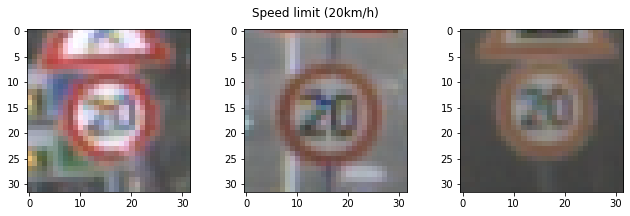

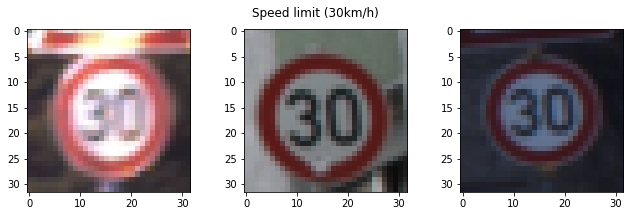

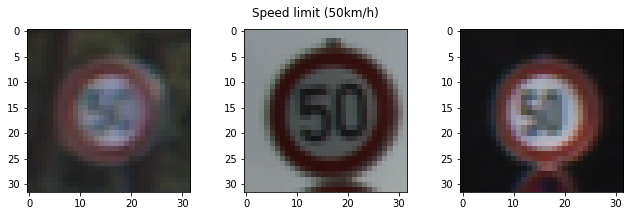

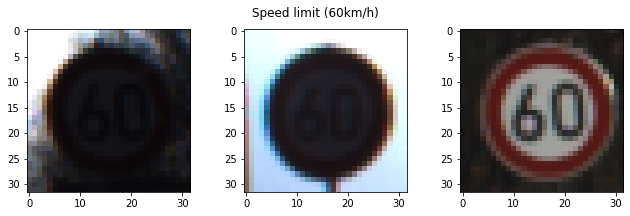

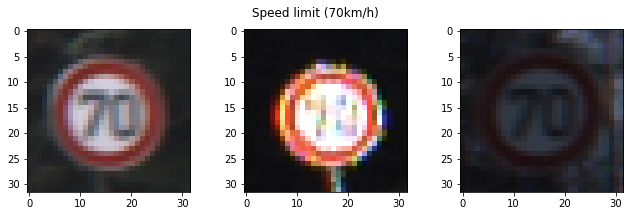

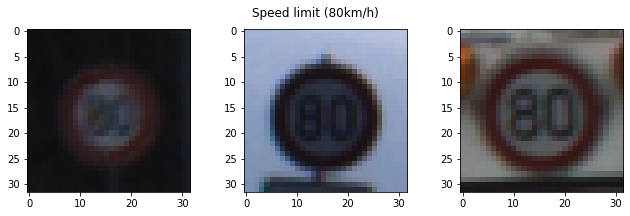

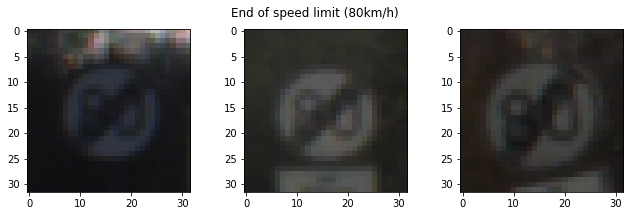

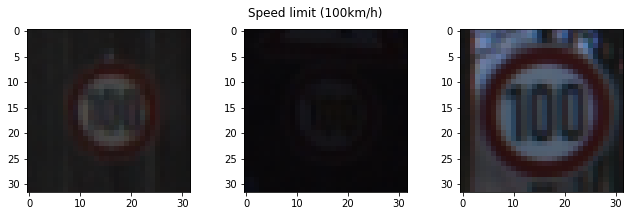

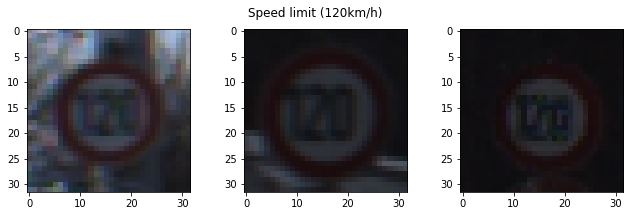

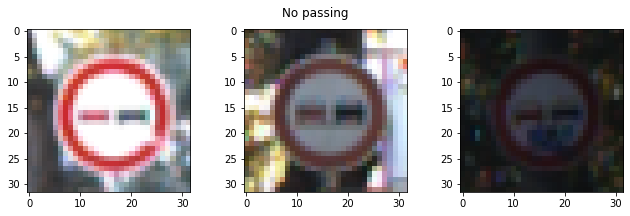

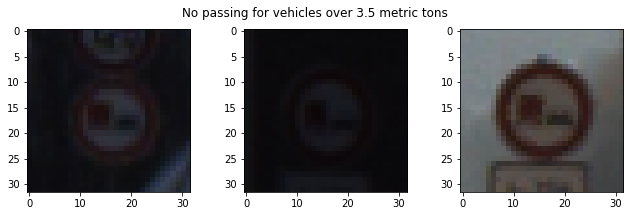

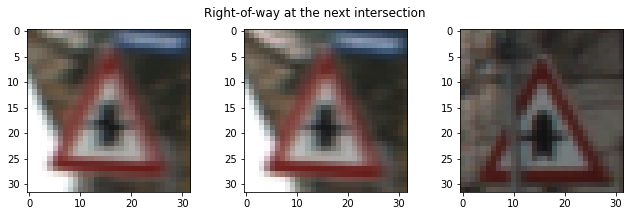

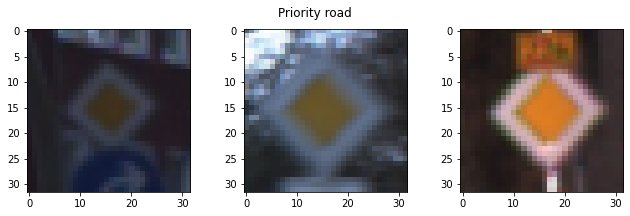

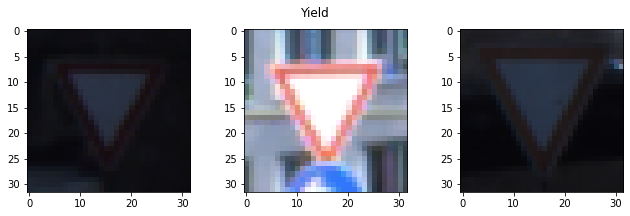

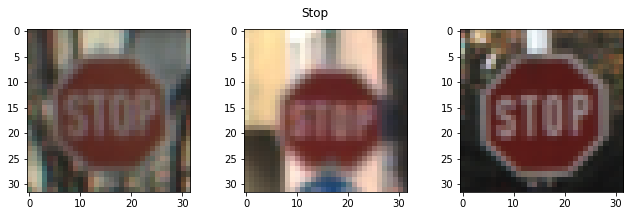

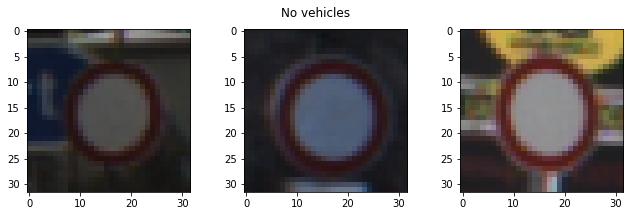

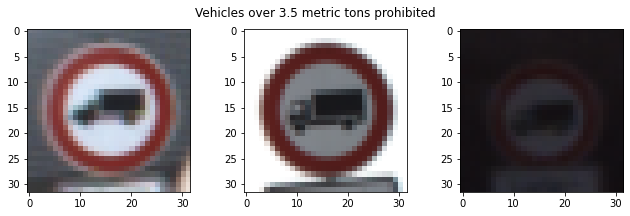

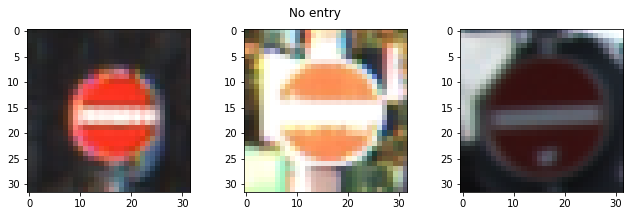

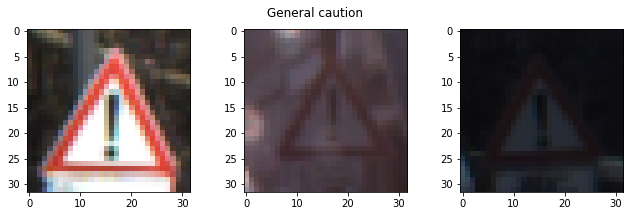

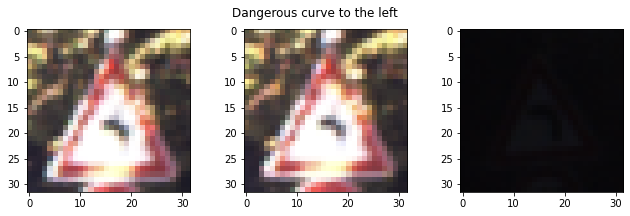

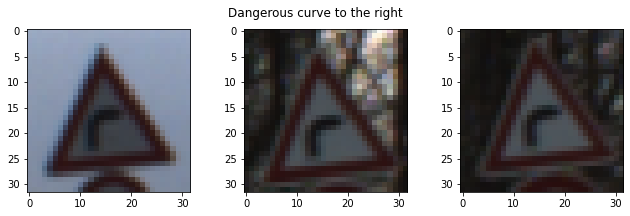

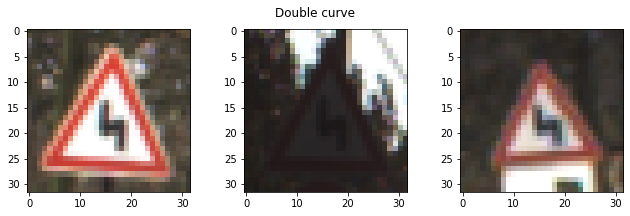

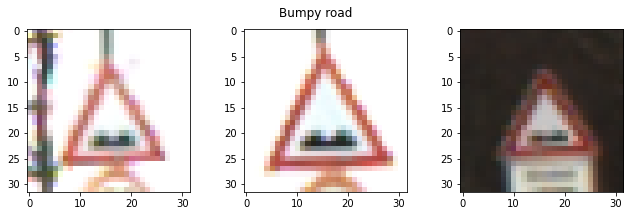

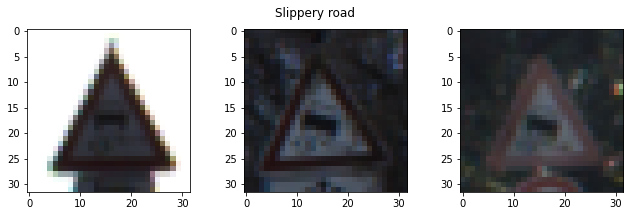

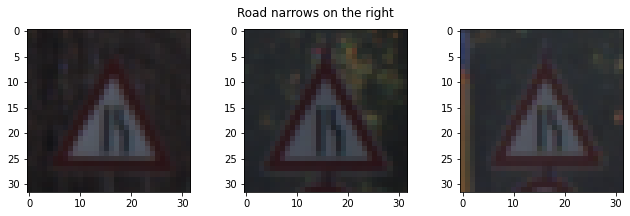

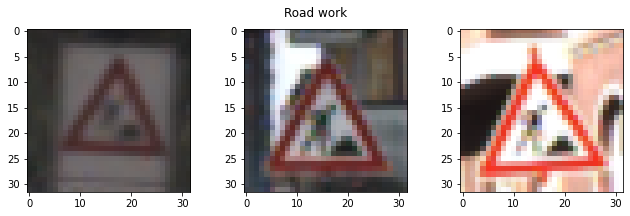

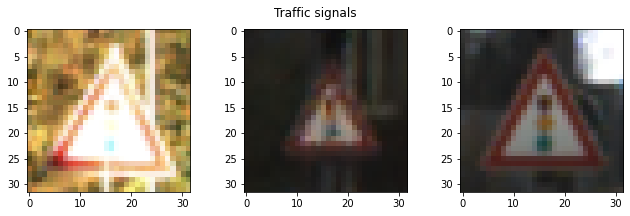

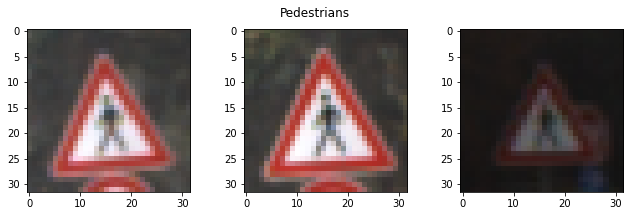

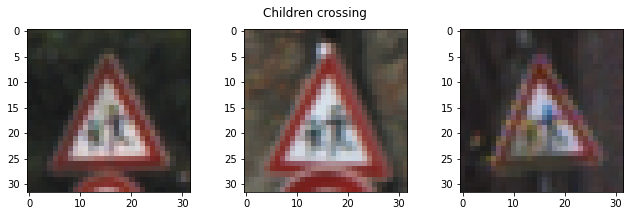

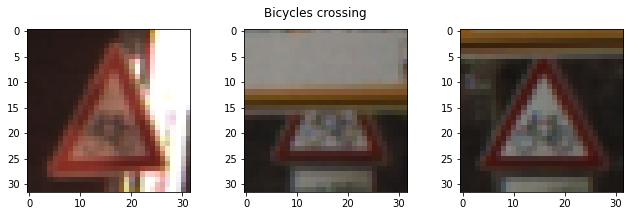

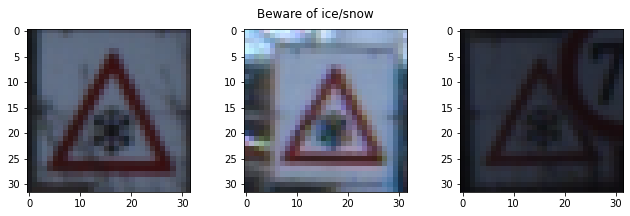

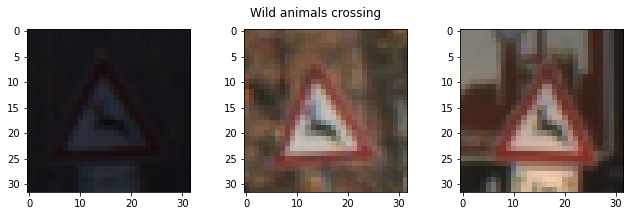

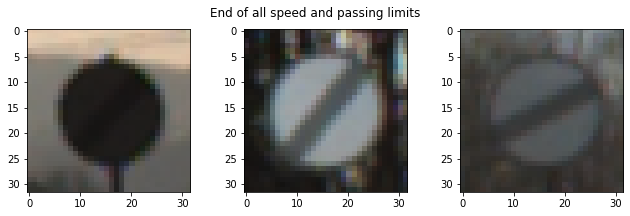

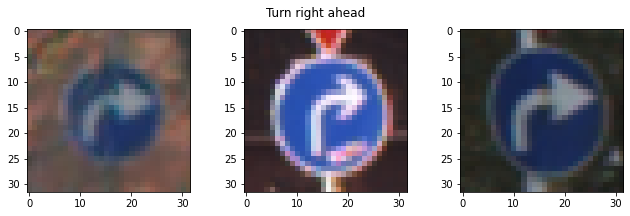

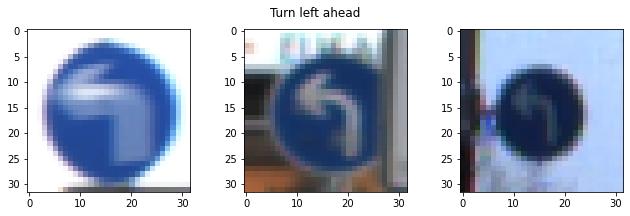

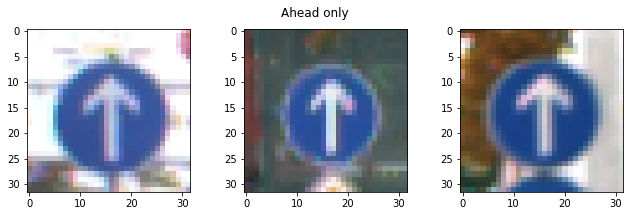

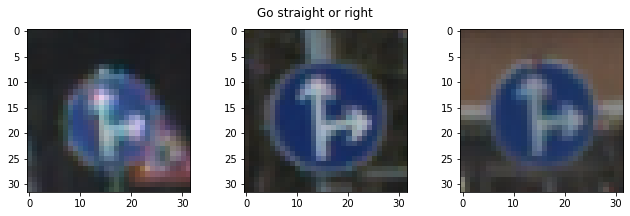

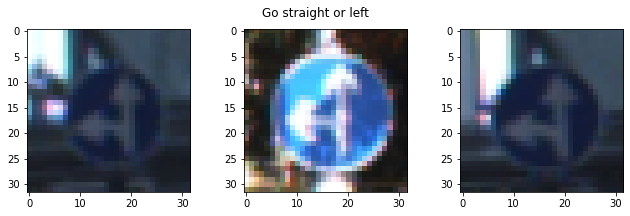

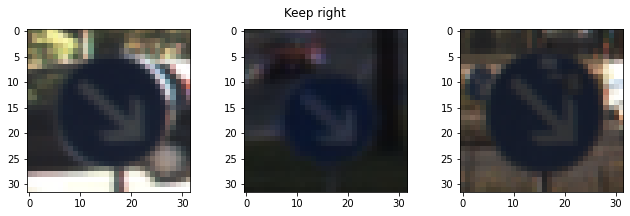

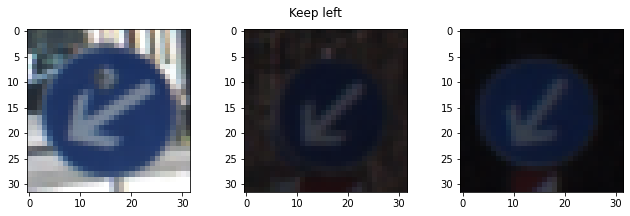

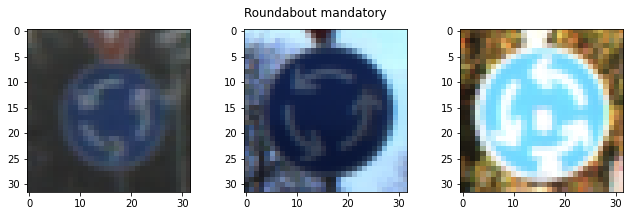

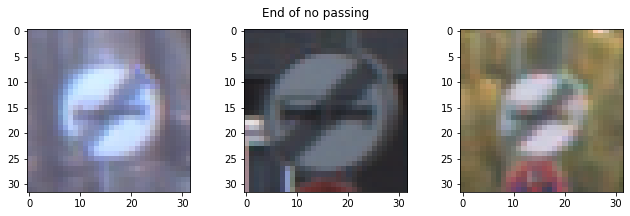

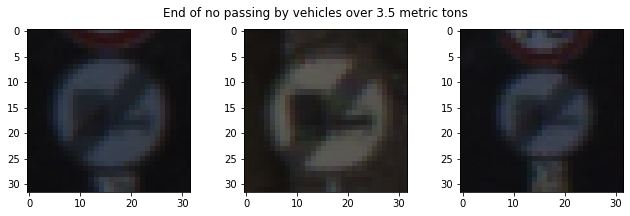

In [5]:
vwr.imShowTrainingSigns(trainingSigns)

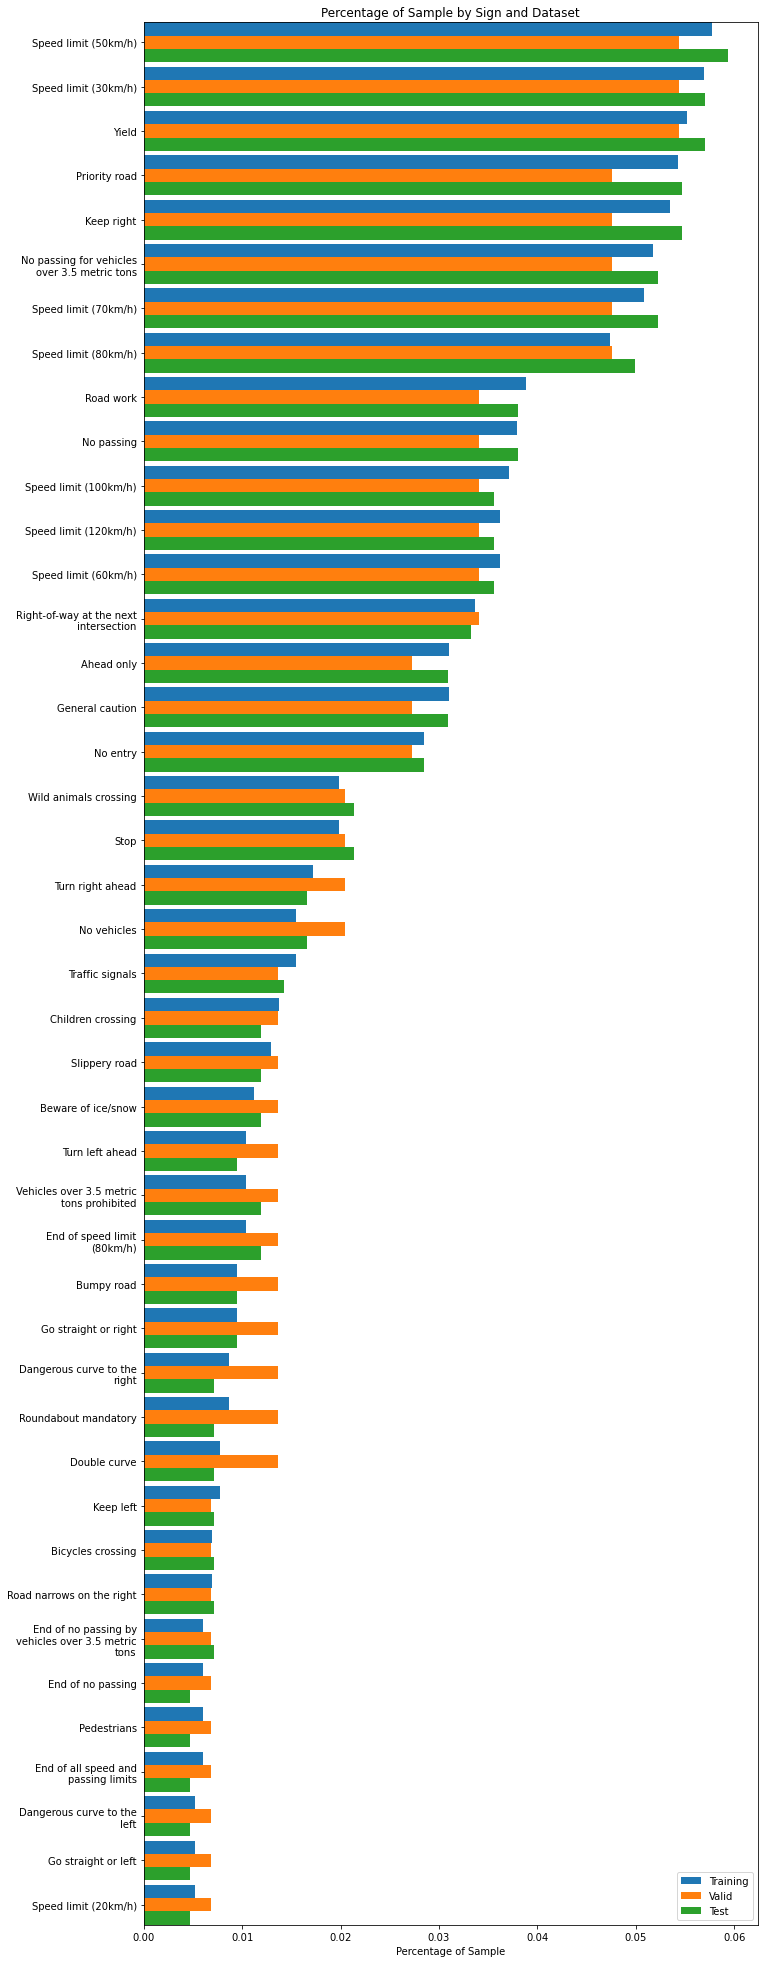

In [6]:
vwr.barhPctBySigns(trainingSigns, validSigns, testSigns)

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import numpy as np
import cv2
import skimage as sk
from skimage.transform import rotate

In [8]:
def RGB_to_norm(img):
    return (np.float32(img) - 128)/128

def norm_to_RGB(norm_img):
    return (np.uint8(128 * norm_img) + 128)

def equalizeHist(orgimg, v_thresh=128): #84
    hsv = cv2.cvtColor(orgimg, cv2.COLOR_RGB2HSV)
    mean_v = np.mean(hsv[:,:,2])
    if mean_v < v_thresh:
        equ = cv2.equalizeHist(hsv[:,:,2])
        hsv[:,:,2] = equ
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    else:
        img = orgimg
    return img

image_processors = [equalizeHist, RGB_to_norm]

# https://medium.com/@thimblot/data-augmentation-boost-your-image-dataset-with-few-lines-of-python-155c2dc1baec

def shift(image):
    d = random.randint(1, 6)
    direction = random.choice([1, 2, 3, 4])
    if direction == 1:
        image[:-d] = image[d:]
    elif direction == 2:
        image[d:] = image[:-d]
    elif direction == 3:
        image[:,d:] = image[:,:-d]
    else:
        image[:,:-d] = image[:,d:]
        
    return image

def crop(image, size=32):
    sizes = np.array(image.shape[:2]) - 32
    lower =  sizes // 2
    upper = image.shape[:2] - (lower + (sizes % 2))
    img = image[lower[0]:upper[0], lower[1]:upper[1]]
    return img

def zoom(image):
    scale = random.uniform(1.0, 1.6)
    img = sk.transform.rescale(image, scale, multichannel=True, preserve_range=True).astype(np.uint8)
    return crop(img)

def rotate (image):
    deg = random.uniform(-15, 15)
    return sk.transform.rotate(image, deg, preserve_range=True).astype(np.uint8)

def preserve(image):
    return image.astype(np.uint8)

def fakeify(image):
    f = random.choices ([preserve, rotate, zoom, shift], weights=[1, 1, 1, 1])[0]
    return f(image)


TrafficSignsDataset-2584 | Original images and labels restored.


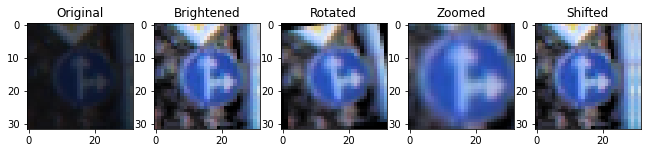

In [70]:
trainingSigns.restoreOrgImages()

org_image = trainingSigns.X[1000].copy()
brt_image = equalizeHist(org_image.copy())
rot_image = rotate(brt_image.copy())
zm_image  = zoom(brt_image.copy())
shf_image = shift(brt_image.copy())

images = [org_image, brt_image, rot_image, zm_image, shf_image]
titles  = ["Original", "Brightened", "Rotated", "Zoomed", "Shifted"]

vwr.imshowImages(images, titles)


In [10]:
trainingSigns.restoreOrgImages()
trainingSigns.addFakes([fakeify])

TrafficSignsDataset-9840 | Original images and labels restored.
TrafficSignsDataset-9840 | Adding fake images...
TrafficSignsDataset-9840 | Added 1830 fake images for sign classId 0.
TrafficSignsDataset-9840 | Added 30 fake images for sign classId 1.
TrafficSignsDataset-9840 | Added 750 fake images for sign classId 3.
TrafficSignsDataset-9840 | Added 240 fake images for sign classId 4.
TrafficSignsDataset-9840 | Added 360 fake images for sign classId 5.
TrafficSignsDataset-9840 | Added 1650 fake images for sign classId 6.
TrafficSignsDataset-9840 | Added 720 fake images for sign classId 7.
TrafficSignsDataset-9840 | Added 750 fake images for sign classId 8.
TrafficSignsDataset-9840 | Added 690 fake images for sign classId 9.
TrafficSignsDataset-9840 | Added 210 fake images for sign classId 10.
TrafficSignsDataset-9840 | Added 840 fake images for sign classId 11.
TrafficSignsDataset-9840 | Added 120 fake images for sign classId 12.
TrafficSignsDataset-9840 | Added 90 fake images for sig

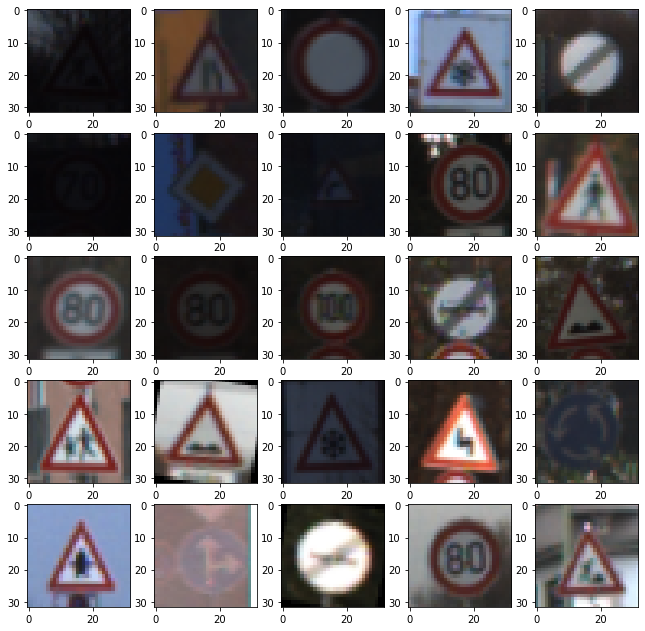

In [11]:
vwr.imShowTrainingSigns5x5(trainingSigns)

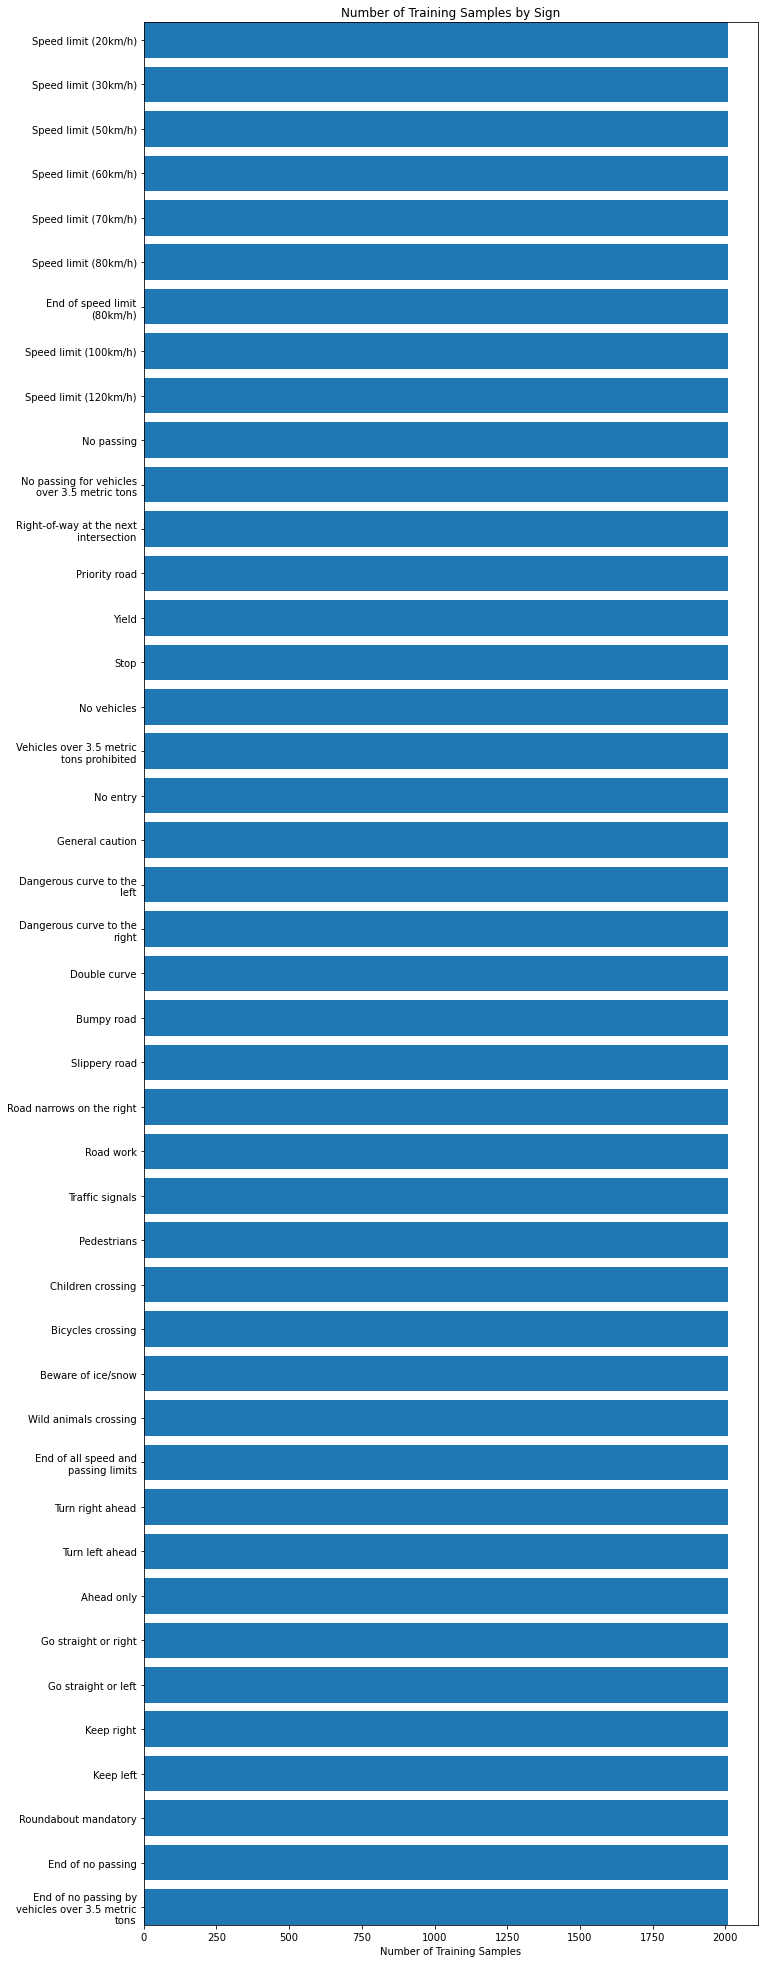

In [12]:
vwr.barhCountTrainingSigns(trainingSigns)

In [13]:
trainingSigns.processImages(image_processors)

validSigns.restoreOrgImages()
validSigns.processImages(image_processors)

testSigns.restoreOrgImages()
testSigns.processImages(image_processors)

TrafficSignsDataset-9840 | Processing images...
TrafficSignsDataset-9840 | Applying equalizeHist() to images.
TrafficSignsDataset-9840 | Applying RGB_to_norm() to images.
TrafficSignsDataset-9840 | ...images processed.
TrafficSignsDataset-9672 | Original images and labels restored.
TrafficSignsDataset-9672 | Processing images...
TrafficSignsDataset-9672 | Applying equalizeHist() to images.
TrafficSignsDataset-9672 | Applying RGB_to_norm() to images.
TrafficSignsDataset-9672 | ...images processed.
TrafficSignsDataset-8776 | Original images and labels restored.
TrafficSignsDataset-8776 | Processing images...
TrafficSignsDataset-8776 | Applying equalizeHist() to images.
TrafficSignsDataset-8776 | Applying RGB_to_norm() to images.
TrafficSignsDataset-8776 | ...images processed.


In [14]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from PIL import Image

W0206 09:33:44.068050  3264 __init__.py:329] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


In [15]:
def conv2D(x, output_shape, s=1, mu=0, sigma=0.1, activation=tf.nn.relu):
    
    input_shape = x.shape.as_list()[1:]
    
    input_depth  = input_shape[2]
    output_depth = output_shape[2]
    
    stride = [1, s, s, 1]
    
    # size of filter (length=Width)
    # ref: lesson 12: Solution: Convolution Output Shape for "VALID" padding
    f_ht  = input_shape[0] - output_shape[0]*s + 1
    f_wid = input_shape[1] - output_shape[1]*s + 1
    
    # shape of weights
    w_shape = (f_ht, f_wid, input_depth, output_depth)
    
    w = tf.Variable(tf.truncated_normal(w_shape, mu, sigma))
    b = tf.Variable(tf.zeros(output_depth))
    c = tf.nn.conv2d(x, w, stride, padding='VALID') + b
    a = activation(c)
    
    return a


def pooling(x, output_shape, s=2, pool=tf.nn.max_pool):
    
    input_shape = x.shape.as_list()[1:]
    input_depth = input_shape[2]
    
    # size of filter
    # ref: lesson 23: Quiz: Pooling Mechanics
    f_ht  = input_shape[0] - (output_shape[0] - 1) * s
    f_wid = input_shape[1] - (output_shape[1] - 1) * s
    
    fil    = [1, f_ht, f_wid, 1]
    stride = [1, s, s, 1]
    
    p = pool(x, fil, stride, padding='VALID')
    
    return p


def connected(x, output_shape,  mu=0, sigma=0.1, activation=tf.nn.relu):
    input_shape = x.shape.as_list()[1]
    output_shape = output_shape[0]
    w_shape = (input_shape, output_shape)
    
    w = tf.Variable(tf.truncated_normal(w_shape, mu, sigma))
    b = tf.Variable(tf.zeros(output_shape))
    z = tf.add(tf.matmul(x, w), b)
    
    if activation is None:
        a = z
    else:
        a = activation(z)
    
    return a


In [16]:
class Layer():
    def __init__(self, output_shape=None):
        self.output_shape = output_shape
        self.tensor = None
        self.model = None
        self.setName()
        return
    
    def setName(self):
        self.name = "Layer"
        return
    
    def summary(self):
        return self.name.ljust(10) + ":" + str(self.tensor.shape)
    
    def connect(self, *prev_layers):
        self.tensor = prev_layers[0].tensor
        return self
    
    def owner(self, model = None):
        if model is not None:
            self.model = model
        return self.model

    
class Input(Layer):
    
    def __init__(self, X):
        
        super().__init__(self)
        self.tensor = X
        
    def setName(self):
        self.name = "Input"
        return
    
    
class Conv2D(Layer):

    def setName(self):
        self.name = "Conv2D"
        return
    
    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.tensor = conv2D(prev_layer[0].tensor, self.output_shape)
        return self
    

class Pooling(Layer):
    
    def setName(self):
        self.name = "Pooling"
        return
    
    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.tensor = pooling(prev_layer[0].tensor, self.output_shape)
        return self
    
    
class Dropout(Layer):
    
    def setName(self):
        self.name = "Dropout"
        return

    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.keep_prob = self.model.keep_prob
        self.tensor = tf.nn.dropout(prev_layer[0].tensor, self.keep_prob)
        return self
    

class Flatten(Layer):
    
    def setName(self):
        self.name = "Flatten"
        return

    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.tensor = flatten(prev_layer[0].tensor)
        return self
    
    
class Connected(Layer):

    def setName(self):
        self.name = "Connected"
        return
    
    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.tensor = connected(prev_layer[0].tensor, self.output_shape)
        return self


In [17]:
class Model:
    
    def __init__(self, name, input_shape, n_classes):
        self.logger = Logger('Model', self)
        
        self.name = name
        
        x_shape = (None, input_shape[0], input_shape[1], input_shape[2])
        self.x  = tf.placeholder(tf.float32, x_shape)
        
        self.input_layer = Input(self.x)
        self.input_layer.owner(self)
        
        self.y         = tf.placeholder(tf.int32, (None))
        self.keep_prob = tf.placeholder(tf.float32)

        self.n_classes = n_classes
        self.logits    = None
        self.saver     = None 
        self.acc_history = None
        
        return
    
    def inputLayer(self):
        return self.input_layer
    
    def connectLogits(self, prev_layer):
    
        self.logits = connected(prev_layer.tensor, [self.n_classes], activation=None)

        oh_labels      = tf.one_hot(self.y, self.n_classes)
        losses         = tf.nn.softmax_cross_entropy_with_logits(labels=oh_labels, logits=self.logits)
        self.mean_loss = tf.reduce_mean(losses)
        
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(oh_labels, 1))
        self.tot_correct   = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))
    
    def accuracy(self, X_data, y_data, batch_size):
        
        num_examples = len(X_data)
        total_correct = 0
        sess = tf.get_default_session()        
        
        for offset in range(0, num_examples, batch_size):
            
            batch_x   = X_data[offset:offset+batch_size] 
            batch_y   = y_data[offset:offset+batch_size]
            feed_dict = {self.x: batch_x, 
                         self.y: batch_y, 
                         self.keep_prob: 1.0}
            
            batch_correct = sess.run(self.tot_correct, feed_dict=feed_dict)
            total_correct += batch_correct
            
        return round (total_correct / num_examples, 3)
    
    def saveModel(self):
        
        sess = tf.get_default_session()
        self.saver.save(sess, "checkpoints/" + self.name)
        msg = "{} saved."
        self.logger.log(msg.format(self.name))
        
        return
    
    def afterEpoch(self, epoch, i, acc, acc_save, hi_acc):
        self.acc_history.append(acc)
        i += 1
        if acc > acc_save:
            if acc > hi_acc:
                i = 0
                hi_acc = acc
                msg = "Epoch {:4d} - New High Acc: {:.3f}"
                self.logger.log(msg.format(epoch + 1, hi_acc))
                
                self.saveModel()
            else:
                msg = "Epoch {:4d} - Acc: {:.3f} - Highest: {:.3f}"
                self.logger.log(msg.format(epoch + 1, acc, hi_acc))
        elif hi_acc > 0:
            msg = "Epoch {:4d} -  Acc: {:.3f} - Highest: {:.3f}"
            self.logger.log(msg.format(epoch + 1, acc, hi_acc))
        else:
            msg = "Epoch {:4d} - Acc: {:.3f}"
            self.logger.log(msg.format(epoch + 1, acc))

        epoch += 1
            
        return epoch, i, hi_acc
    
    def train(self, training_data, validation_data, epochs_done, batch_size, lr=0.001, 
              acc_save=0.93, acc_done=0.982, keep_prob=1.0, ):
        
        X_train = training_data[0]
        y_train = training_data[1]
        
        X_valid = validation_data[0]
        y_valid = validation_data[1]
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        minimizer = optimizer.minimize(self.mean_loss)
        
        self.saver = tf.train.Saver()
        
        self.logger.log("Training...")
        with tf.Session() as sess:
            try:
            
                sess.run(tf.global_variables_initializer())

                num_examples = len(X_train)

                self.acc_history = []
                hi_acc = 0
                epoch = 0
                i = 0
                acc = 0
                while (i < epochs_done) and (acc < acc_done):

                    X_train, y_train = shuffle(X_train, y_train)

                    for offset in range(0, num_examples, batch_size):
                        end       = offset + batch_size
                        batch_x   = X_train[offset:end] 
                        batch_y   = y_train[offset:end]
                        feed_dict = {self.x        : batch_x, 
                                     self.y        : batch_y, 
                                     self.keep_prob: keep_prob}
                        sess.run(minimizer, feed_dict=feed_dict)

                    acc = self.accuracy(X_valid, y_valid, batch_size)
                    epoch, i, hi_acc = self.afterEpoch(epoch, i, acc, acc_save, hi_acc)
                    
            # https://stackoverflow.com/a/45033800
            except KeyboardInterrupt:
                self.logger.log("Keyboard interrupt.")

        msg = "...training complete. Highest accuracy: {:.3f}."
        self.logger.log(msg.format(hi_acc))        
        
        return
    
    def accHist(self):
        return self.acc_history
    
    def test(self, test_data):
        
        X_test = test_data[0]
        y_test = test_data[1]
        
        with tf.Session() as sess:
            self.restore()
            test_acc = self.accuracy(X_test, y_test, batch_size=128)
            msg = "Test accuracy: {:.3f}."
            self.logger.log(msg.format(test_acc))
            
        return
    
    def predict(self, images, top=5):
        
        with tf.Session() as sess:
            
            self.restore()
            predictions = []
            
            self.logger.log("Classifying images...")
            
            op_top_k  = tf.nn.top_k(tf.nn.softmax(self.logits), top)
            feed_dict = {self.x        : images, 
                         self.keep_prob: 1.0}

            predictions = sess.run(op_top_k, feed_dict=feed_dict)

            msg = "...{} images classified."
            self.logger.log(msg.format(len(images)))
            
        return predictions
    
    def restore(self):

        saver = tf.train.Saver()
        sess  = tf.get_default_session()
        saver.restore(sess, "checkpoints/" + self.name)
        
        msg = "{} restored."
        self.logger.log(msg.format(self.name))        
        
        return
    
class Sequential(Model):
    
    def __init__(self, name, input_shape, n_classes):
        
        super().__init__(name, input_shape, n_classes)
        self.layers    = []
        
        return
        
    def addLayer(self, layer):
        
        self.layers.append(layer)
        
        return
    
    def assemble(self):
        
        prev_layer = self.input_layer
        for layer in self.layers:
            prev_layer = layer.connect(prev_layer)
            
        self.connectLogits(prev_layer)
            
        return 
    
    def summarize(self):
        
        msg = "     Summary for {}:"
        self.logger.log(msg.format(self.name))
        self.logger.log("----------------------------------")
        msg = "     Input".ljust(15) + ":{}"
        self.logger.log(msg.format(self.x.shape))
        self.logger.log("----------------------------------")
        
        n = 0
        for layer in self.layers:
            msg = "{:<2} : " + layer.summary()
            self.logger.log(msg.format(n))
            n += 1

        self.logger.log("----------------------------------")
        msg = "     Logits".ljust(15) + ":{}"
        self.logger.log(msg.format(self.logits.shape))
        self.logger.log("----------------------------------")
            
        return
    
    def eval_layer(self, i, img):
        
        msg = "Evaluating layer {}."
        self.logger.log(msg.format(i))
        
        tensor = self.layers[i].tensor
        feed_dict = {self.x        : [img], 
                     self.keep_prob: 1.0}

        with tf.Session() as sess:
            
            self.restore()
            eval_outputs = tensor.eval(session=sess, feed_dict=feed_dict)
            
        msg = "Output shape: {}."
        self.logger.log(msg.format(eval_outputs.shape))

        return eval_outputs




In [ ]:

'''
0.981  batch 256, batch 320(982, all wiki), 
m.addLayer   (Conv2D ([28, 28, 12], probe=True))
m.addLayer   (Pooling([14, 14, 12]))
m.addLayer   (Conv2D ([10, 10, 32], probe=True))
m.addLayer   (Pooling([5, 5, 16]))
m.addLayer   (Flatten())
m.addLayer   (Connected([240]))
m.addDropout (Dropout())    
m.addLayer   (Connected([168]))
m.addDropout (Dropout())
m.addOutput  (Output())

gets all wikipedia .969 valacc, .952 test acc, bs=256, keep_prob 0.5
m.addLayer   (Conv2D ([28, 28, 24], probe=True))
m.addLayer   (Pooling([14, 14, 24]))
m.addLayer   (Conv2D ([10, 10, 64], probe=True))
m.addLayer   (Pooling([5, 5, 64]))
m.addLayer   (Flatten())
m.addLayer   (Connected([1024]))
m.addDropout (Dropout())    
m.addLayer   (Connected([1024]))
m.addDropout (Dropout())
m.addOutput  (Output())
'''
    

notLenet = Sequential("notLeNet", input_shape=image_shape, n_classes=n_classes)

notLenet.addLayer (Conv2D   ([32, 32, 1]))
#notLenet.addLayer (Pooling  ([16, 16]))
notLenet.addLayer (Conv2D   ([28, 28, 24]))
notLenet.addLayer (Pooling  ([14, 14]))
notLenet.addLayer (Conv2D   ([10, 10, 64]))
notLenet.addLayer (Pooling  ([5, 5]))
notLenet.addLayer (Flatten  ())
notLenet.addLayer (Connected([240]))
notLenet.addLayer (Dropout  ())    
notLenet.addLayer (Connected([168]))
notLenet.addLayer (Dropout  ())
    
notLenet.assemble()
notLenet.summarize()

In [ ]:
notLenet.train(trainingSigns.data(), validSigns.data(), batch_size=336, 
        epochs_done=128, acc_done=0.987, keep_prob=0.5)

In [ ]:
vwr.plotAccHist(notLenet.name, notLenet.accHist())

In [ ]:
notLenet.test(trainingSigns.data())

In [ ]:
notLenet.test(testSigns.data())

In [26]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

folder_name = 'traffic_signs/wikipedia/'
wiki_traffic_signs = TrafficSignsDataset (folder_name, n_classes)

TrafficSignsDataset-2960 | Loading signs from traffic_signs/wikipedia/...
TrafficSignsDataset-2960 | Loaded 10,No passing for vehicles over 3.5 metric tons.png with label 10.
TrafficSignsDataset-2960 | Loaded 19,Dangerous curve to the left.png with label 19.
TrafficSignsDataset-2960 | Loaded 21,Double curve.png with label 21.
TrafficSignsDataset-2960 | Loaded 22,Bumpy road.png with label 22.
TrafficSignsDataset-2960 | Loaded 24,Road narrows on the right.png with label 24.
TrafficSignsDataset-2960 | Loaded 26,Traffic signals.png with label 26.
TrafficSignsDataset-2960 | Loaded 29,Bicycles crossing.png with label 29.
TrafficSignsDataset-2960 | Loaded 3,Speed limit (60kmh).png with label 3.
TrafficSignsDataset-2960 | Loaded 30,Beware of ice-snow.png with label 30.
TrafficSignsDataset-2960 | Loaded 32,End of all speed and passing limits.png with label 32.
TrafficSignsDataset-2960 | Loaded 35,Ahead only.png with label 35.
TrafficSignsDataset-2960 | Loaded 40,Roundabout mandatory.png with la

In [27]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

wiki_traffic_signs.restoreOrgImages()
wiki_traffic_signs.processImages(image_processors)


TrafficSignsDataset-2960 | Original images and labels restored.
TrafficSignsDataset-2960 | Processing images...
TrafficSignsDataset-2960 | Applying equalizeHist() to images.
TrafficSignsDataset-2960 | Applying RGB_to_norm() to images.
TrafficSignsDataset-2960 | ...images processed.


In [ ]:
predictions = notLenet.predict(wiki_traffic_signs.X, top=5)

vwr.imShowPredictions(wiki_traffic_signs.org_X, predictions)

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
notLenet.test(wiki_traffic_signs.data())

In [ ]:
plt.imshow(wiki_traffic_signs.org_X[7])

In [ ]:
layer_outputs = notLenet.eval_layer(0, wiki_traffic_signs.X[7])

In [ ]:
vwr.imShowConvOutputs(layer_outputs)

In [ ]:
layer_outputs = notLenet.eval_layer(1, wiki_traffic_signs.X[7])

In [ ]:
vwr.imShowConvOutputs(layer_outputs)

In [18]:
class Concatenate(Layer):
    
    def setName(self):
        self.name = "Concatenate"
        return

    def connect(self, *prev_layers):
        self.model = prev_layers[0].model
        tensors = [layer.tensor for layer in prev_layers]
        self.tensor = tf.concat(tensors, axis=1)
        return self


In [29]:
tf.reset_default_graph()

notSermanet = Model("notSermanet", image_shape, n_classes)

stage_1x1 = Conv2D ([32, 32, 1]).connect(notSermanet.inputLayer())
flatten_1x1 = Flatten().connect(stage_1x1)

stage_1 = Conv2D ([28, 28, 24]).connect(stage_1x1)
stage_1 = Pooling([14, 14]).connect(stage_1)
flatten_1 = Flatten().connect(stage_1)

stage_2 = Conv2D ([10, 10, 64]).connect(stage_1x1)
stage_2 = Pooling([ 5,  5]).connect(stage_2)
stage_2 = Conv2D ([3, 3, 96]).connect(stage_1x1)
flatten_2 = Flatten().connect(stage_2)

stage_3 = Concatenate().connect(flatten_1x1, flatten_1, flatten_2)
stage_3 = Connected([240]).connect(stage_3)
stage_3 = Dropout().connect(stage_3)
stage_3 = Connected([168]).connect(stage_3)
stage_3 = Dropout().connect(stage_3)

notSermanet.connectLogits(stage_3)


In [ ]:
tf.reset_default_graph()

notSermanet = Model("notSermanet", image_shape, n_classes)

stage_1x1 = Conv2D ([32, 32, 1]).connect(notSermanet.inputLayer())

stage_1 = Conv2D ([28, 28, 24]).connect(stage_1x1)
stage_1 = Pooling([14, 14]).connect(stage_1)
flatten_1 = Flatten().connect(stage_1)

stage_2 = Conv2D ([10, 10, 64]).connect(stage_1)
stage_2 = Pooling([ 5,  5]).connect(stage_2)
stage_2 = Conv2D ([3, 3, 96]).connect(stage_2)
flatten_2 = Flatten().connect(stage_2)

stage_3 = Concatenate().connect(flatten_1, flatten_2)
stage_3 = Connected([240]).connect(stage_3)
stage_3 = Dropout().connect(stage_3)
stage_3 = Connected([168]).connect(stage_3)
stage_3 = Dropout().connect(stage_3)

notSermanet.connectLogits(stage_3)


In [35]:
notSermanet.train(trainingSigns.data(), validSigns.data(), batch_size=256, 
        epochs_done=1024, acc_done=0.997, keep_prob=0.5)

Model-0968 | Training...
Model-0968 | Epoch    1 - Acc: 0.785
Model-0968 | Epoch    2 - Acc: 0.850
Model-0968 | Epoch    3 - Acc: 0.872
Model-0968 | Epoch    4 - Acc: 0.895
Model-0968 | Epoch    5 - Acc: 0.885
Model-0968 | Epoch    6 - Acc: 0.905
Model-0968 | Epoch    7 - Acc: 0.892
Model-0968 | Epoch    8 - Acc: 0.911
Model-0968 | Epoch    9 - Acc: 0.919
Model-0968 | Epoch   10 - Acc: 0.915
Model-0968 | Epoch   11 - Acc: 0.913
Model-0968 | Epoch   12 - Acc: 0.907
Model-0968 | Epoch   13 - Acc: 0.916
Model-0968 | Epoch   14 - Acc: 0.913
Model-0968 | Epoch   15 - Acc: 0.912
Model-0968 | Epoch   16 - Acc: 0.916
Model-0968 | Epoch   17 - Acc: 0.923
Model-0968 | Epoch   18 - Acc: 0.915
Model-0968 | Epoch   19 - Acc: 0.927
Model-0968 | Epoch   20 - Acc: 0.922
Model-0968 | Epoch   21 - Acc: 0.917
Model-0968 | Epoch   22 - Acc: 0.917
Model-0968 | Epoch   23 - Acc: 0.925
Model-0968 | Epoch   24 - Acc: 0.925
Model-0968 | Epoch   25 - Acc: 0.920
Model-0968 | Epoch   26 - Acc: 0.920
Model-0968 | 

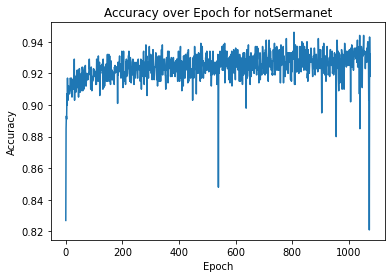

In [31]:
vwr.plotAccHist(notSermanet.name, notSermanet.accHist())

In [32]:
notSermanet.test(trainingSigns.data())

Model-0968 | notSermanet restored.
Model-0968 | Test accuracy: 1.000.


In [33]:
notSermanet.test(testSigns.data())

Model-0968 | notSermanet restored.
Model-0968 | Test accuracy: 0.925.


Model-0968 | notSermanet restored.
Model-0968 | Classifying images...
Model-0968 | ...13 images classified.


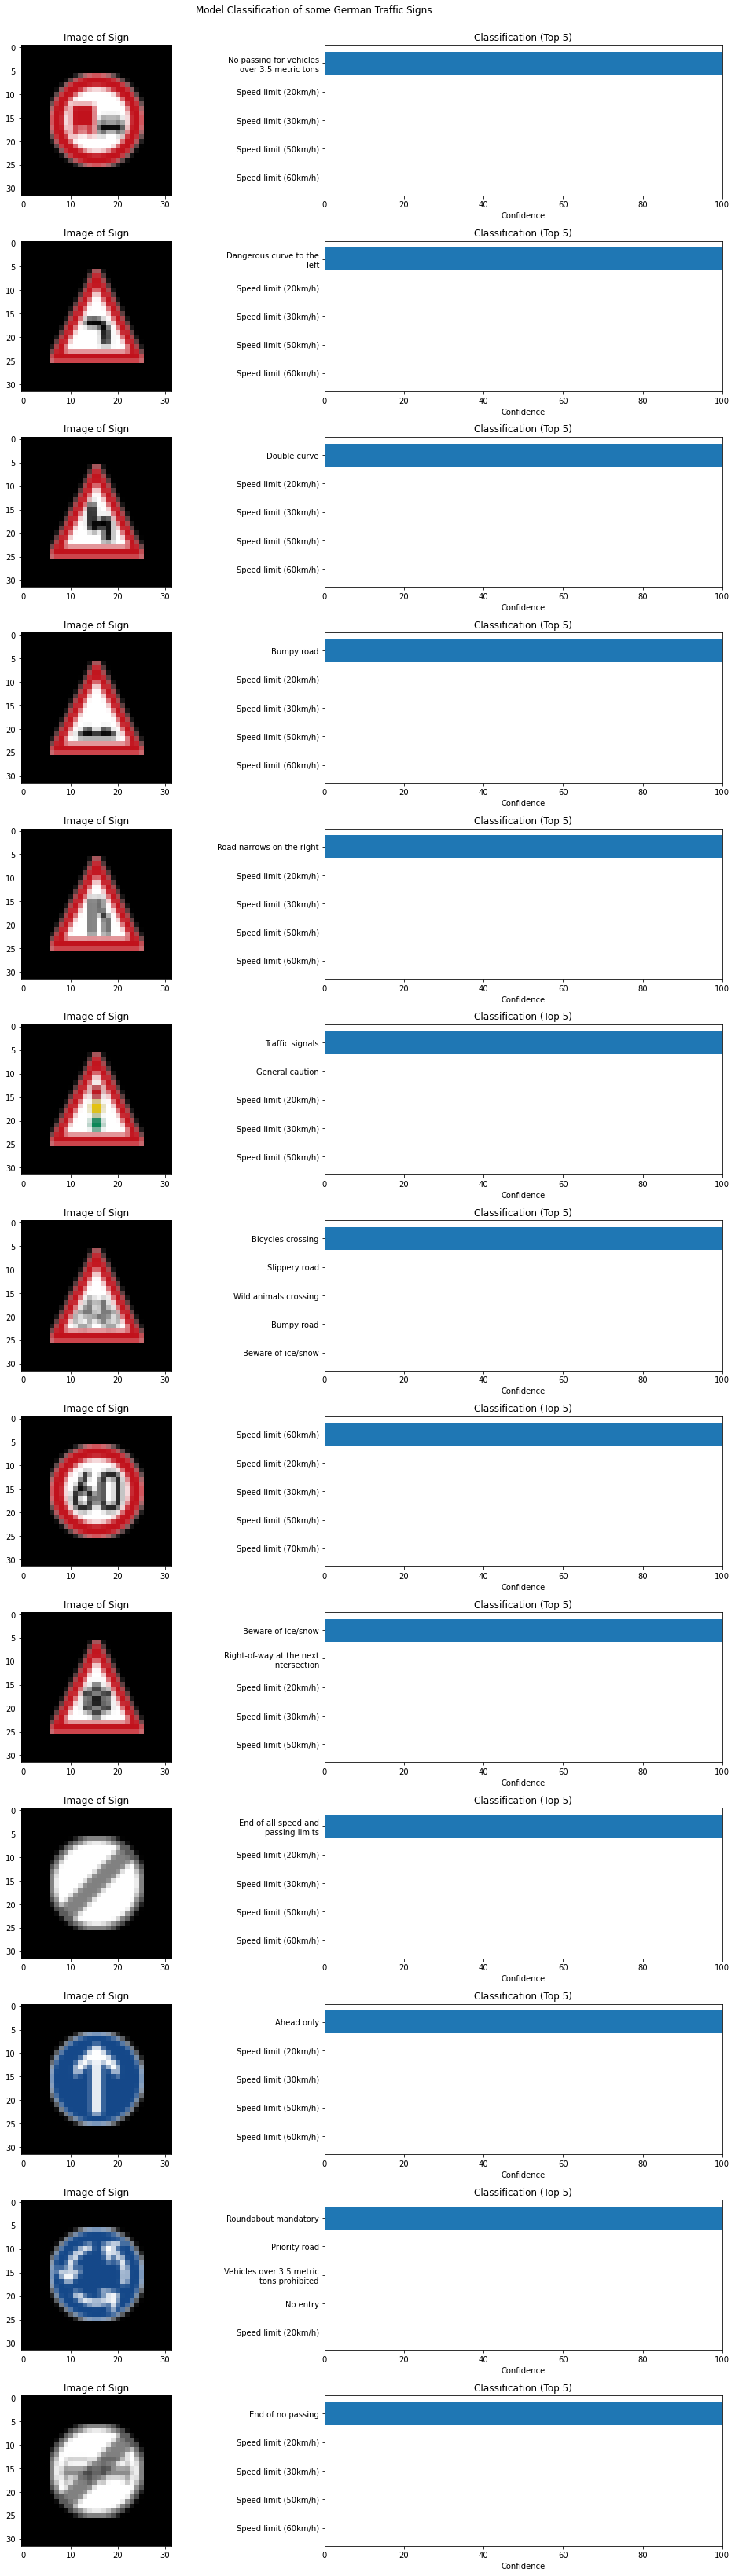

In [34]:
predictions = notSermanet.predict(wiki_traffic_signs.X, top=5)

vwr.imShowPredictions(wiki_traffic_signs.org_X, predictions)

In [ ]:
notSermanet.test(wiki_traffic_signs.data())